# Archetype Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import load_iris

wine = load_iris()

X = wine.data
target = wine.target

In [3]:
from archetypes.sklearn import AA

method_kwargs = {
    "optimizer": "sgd",
    "optimizer_kwargs": {
        "learning_rate": 1e-2,
    },
}

model = AA(n_archetypes=3, max_iter=2_000, tol=1e-4, random_state=10, method="jax")
model.fit(X)

model.archetypes_

Array([[5.4245243 , 2.4346595 , 4.4867387 , 1.560987  ],
       [4.80303   , 3.4788947 , 1.101927  , 0.17460077],
       [7.541169  , 3.1067958 , 6.6729364 , 2.2812047 ]], dtype=float32)

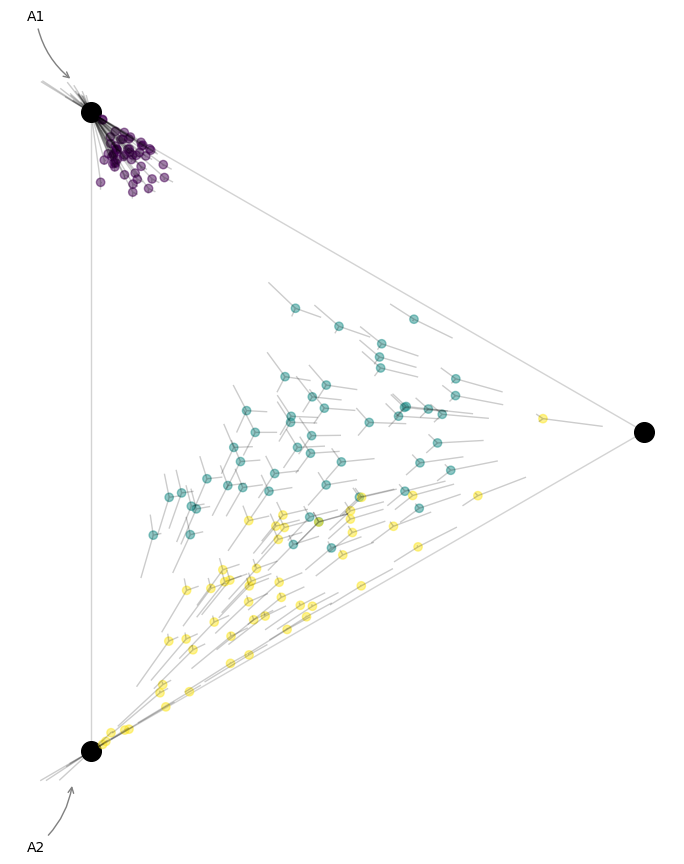

In [4]:
import matplotlib.pyplot as plt
from archetypes.visualization import simplex

plt.figure(figsize=(10, 10))
simplex(model.similarity_degree_, c=target, alpha=0.5, show_circle=False, show_direction=True)

plt.show()